In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorboard
import numpy as np
import logging
from datetime import datetime
import matplotlib.pyplot as plt

from utility import *

logging.getLogger().setLevel(logging.INFO)

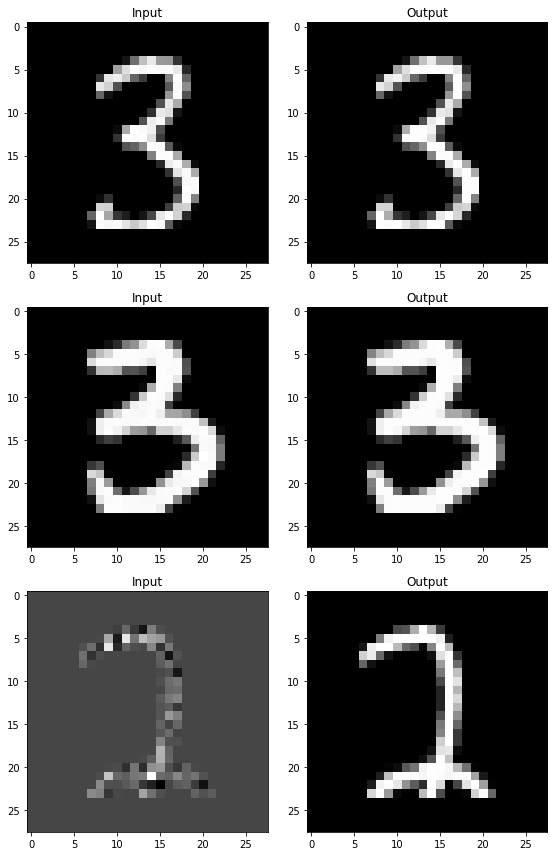

In [2]:
REFRESH_DATA = False
data = get_data(REFRESH_DATA)
plot_image_pairs(data, ('Input', 'Output'), first_n_pairs=3)

In [3]:
(x_train, y_train), (x_val, y_val) = get_train_val_pair(data)
logging.info(f"Total training images: {len(x_train)}")
logging.info(f"Total validation images: {len(x_val)}")

INFO:root:Total training images: 238000
INFO:root:Total validation images: 42000


In [4]:
image_shape = x_train.shape[-2:]
total_pixels = np.prod(image_shape)

In [5]:
inputs = keras.Input(shape=image_shape, name='input_layer')
flatten = keras.layers.Flatten(name='flatten_input_layer')(inputs)
h1 = keras.layers.Dense(128, activation='relu', name='hidden_layer_1') (flatten)
h2 = keras.layers.Dense(256, activation='relu', name='hidden_layer_2') (h1)
h3 = keras.layers.Dense(512, activation='relu', name='hidden_layer_3') (h2)
outputs = keras.layers.Dense(total_pixels, activation='relu', name='output_layer') (h3)
reshape =  keras.layers.Reshape((28,28), name='reshape_output_layer') (outputs)
model = keras.Model(inputs=inputs, outputs=reshape, name = 'MLP')
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='MSE',
    metrics=['accuracy']
)

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28)]          0         
_________________________________________________________________
flatten_input_layer (Flatten (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 128)               100480    
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 256)               33024     
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 512)               131584    
_________________________________________________________________
output_layer (Dense)         (None, 784)               402192    
_________________________________________________________________
reshape_output_layer (Reshap (None, 28, 28)            0       

In [6]:
logdir = "./logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir=logdir,
    histogram_freq=1
)

earlystop_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=1e-4,
    patience=5
)

history = model.fit(
    x_train, 
    y_train, 
    batch_size = 512,
    epochs=50,
    validation_split=0.2,
    use_multiprocessing=True,
    callbacks=[earlystop_callback]
)

Train on 190400 samples, validate on 47600 samples
Epoch 1/50
190400/190400 [==============================] - 7s 39us/sample - loss: 0.0234 - accuracy: 0.4830 - val_loss: 0.0150 - val_accuracy: 0.5474
Epoch 2/50
190400/190400 [==============================] - 7s 34us/sample - loss: 0.0137 - accuracy: 0.5513 - val_loss: 0.0129 - val_accuracy: 0.5588
Epoch 3/50
190400/190400 [==============================] - 7s 37us/sample - loss: 0.0124 - accuracy: 0.5622 - val_loss: 0.0120 - val_accuracy: 0.5660
Epoch 4/50
190400/190400 [==============================] - 7s 36us/sample - loss: 0.0114 - accuracy: 0.5692 - val_loss: 0.0111 - val_accuracy: 0.5720
Epoch 5/50
190400/190400 [==============================] - 7s 37us/sample - loss: 0.0105 - accuracy: 0.5749 - val_loss: 0.0102 - val_accuracy: 0.5795
Epoch 6/50
190400/190400 [==============================] - 7s 37us/sample - loss: 0.0098 - accuracy: 0.5799 - val_loss: 0.0096 - val_accuracy: 0.5820
Epoch 7/50
190400/190400 [=================

In [8]:
from noisy import *

In [9]:
(images, _), _ = keras.datasets.mnist.load_data()
sample_image = images[0]

In [16]:
noise_types = [
    {
    'name': 'Gauss Noise',
    'method': add_gauss_noise
    },
    {
    'name': 'Salt & Paper',
    'method': add_salt_and_pepper_noise
    },
    {
    'name': 'Poisson Noise',
    'method': add_poisson_noise 
    },
    {
    'name': 'Speckle Noise',
    'method': add_speckle_noise
    }
]
    

test_dataset = []
for noise_type in noise_types:
    test_dataset.append({
        'noise_type': noise_type['name'],
        'original': sample_image / 255.0,
        'noisy_image': noise_type['method'](sample_image) / 255.0
    })

In [17]:
for test_data in test_dataset:
    test_data['denoised_image'] = np.squeeze(model.predict(np.expand_dims(test_data['noisy_image'], axis=0)), axis = 0)

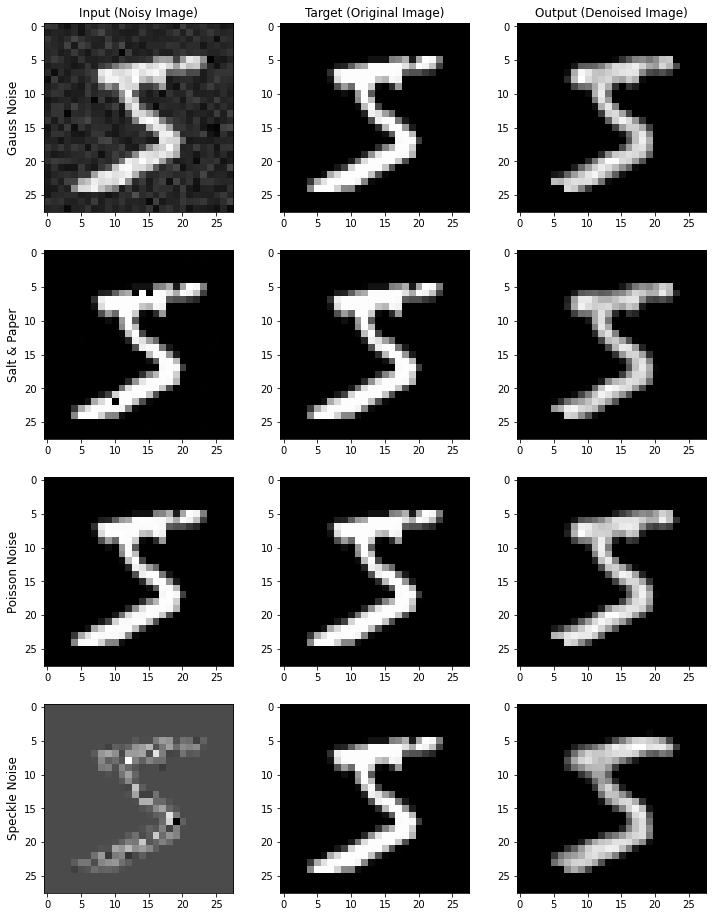

In [21]:
fig_size = (12, 16)
fig, axes = plt.subplots(4, 3, figsize = fig_size)
for idx, test_data in enumerate(test_dataset):
    ax = axes[idx, 0]
    ax.set_ylabel(test_data['noise_type'], size='large')
        
    ax = axes[idx, 0]
    ax.imshow(test_data['noisy_image'], cmap = 'gray')
    if idx == 0:
        ax.set_title('Input (Noisy Image)')
    
    ax = axes[idx, 1]
    ax.imshow(test_data['original'], cmap = 'gray')
    if idx == 0:
        ax.set_title('Target (Original Image)')
    
    ax = axes[idx, 2]
    ax.imshow(test_data['denoised_image'], cmap = 'gray')
    if idx == 0:
        ax.set_title('Output (Denoised Image)')
plt.show()